Experiment on using various distortion parameterization to map AI-predicted depth map to a ground truth depth map, which can be useful for 3D reconstruction tasks.

From findings of `depth_fitting_01`, all models use linear least squares.

This is tested on a depth map with a much higher range. Masking is done for predicted sky. A logarithmic map is applied to depth maps.

For the new test image, "Linear least squares, embedded and fused depth and positions" with nd=3 and npos=1 still performs the best.


In [ ]:
import cv2
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import sys, os
depth_anything_path = "/home/harry7557558/GitHub/external/Depth-Anything-V2/"
sys.path += [depth_anything_path]
current_directory = os.getcwd()
os.chdir(depth_anything_path)

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

# encoder = 'vitl'
encoder = 'vits'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(device).eval()

model_s = DepthAnythingV2(**model_configs['vits'])
model_s.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_vits.pth', map_location='cpu'))
model_s = model_s.to(device).eval()

Load image + Predict depth

Image size: (640, 480)


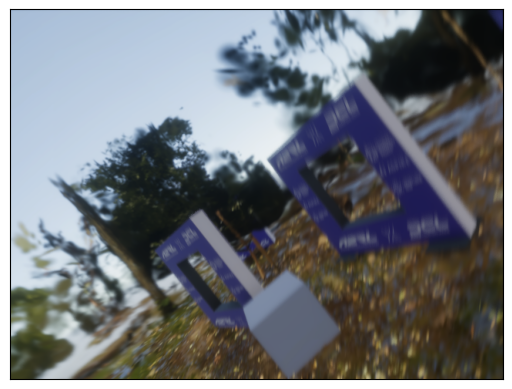

113.69997001020238 ms
(3, 480, 640) (480, 640)
0.0 3.419564962387085
0.5253547430038452 1.0000001192092896


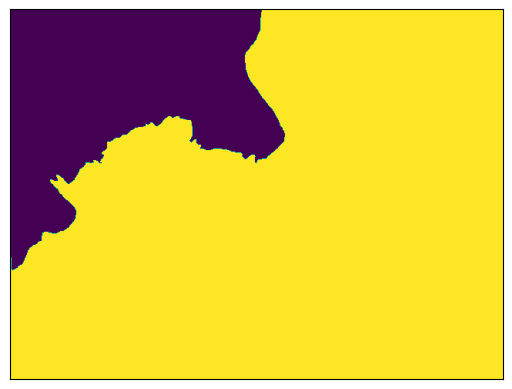

0.781796875


In [103]:
from PIL import Image

filename = "/home/harry7557558/Unity/Projects/ssplat-rt/DataExport/yolo_gates/gates_labeled_20241030/woods/00107.png"

x = Image.open(filename).convert("RGB")

print("Image size:", x.size)

import matplotlib.pyplot as plt
plt.imshow(x)
plt.xticks([])
plt.yticks([])
plt.show()

x = np.array(x)

from time import perf_counter
with torch.no_grad():
    torch.cuda.synchronize()
    time0 = perf_counter()

    pred_depth = model.infer_image(x)
    pred_depth_s = model_s.infer_image(x)

    torch.cuda.synchronize()
    time1 = perf_counter()
    print(1000*(time1-time0), 'ms')

pred_depth /= np.mean(pred_depth)
pred_depth_s /= np.mean(pred_depth_s)

x = np.transpose(x, (2, 0, 1)).astype(np.float32) / 255.0
print(x.shape, pred_depth.shape)
print(pred_depth.min().item(), pred_depth.max().item())
print(np.median(pred_depth).item(), pred_depth.mean().item())

depth_mask = (pred_depth_s > 1e-4)
plt.imshow(depth_mask)
plt.xticks([])
plt.yticks([])
plt.show()
print(depth_mask.mean())

Load GT depth

Generated using https://github.com/harry7557558/ssplat-rt-unity (currently private)

In [104]:
def load_depth_map(file_path):
    with open(file_path, 'rb') as f:
        depth_map = np.fromfile(f, dtype=np.float32)
    return depth_map.reshape(x[0].shape)

def decompose_camera(mat):
    R = mat[:3,:3].reshape((1,1,3,3))
    P = mat[3:,:3].reshape((1,1,1,3))
    T = mat[:3,3:].reshape((1,1,3,1))
    S = mat[3:,3:].reshape((1,1,1,1))
    return R, P, T, S

def project_depth(depth, shader_proj):
    h, w = depth.shape
    R, P, T, S = decompose_camera(shader_proj)
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    #u, v = np.meshgrid(u, -v)
    u, v = np.meshgrid(u, v)
    c = np.stack((u, v, depth), axis=2).reshape((h,w,3,1))
    A = R - np.matmul(c, P)
    b = c*S - T
    cam_pos = -np.linalg.solve(R, T).reshape((1,1,3))
    return cam_pos, np.linalg.solve(A, b.squeeze(-1))

raw_depth = load_depth_map(filename.replace(".png", "_depth.bin"))
# print(depth)

import json
with open(filename[:filename.rfind('/')]+"/scene_info.json") as fp:
    scene_info = json.load(fp)
scene_data = scene_info[filename[filename.rfind('/')+1:filename.rfind('.')]]
shader_proj = np.array(scene_data['shaderProjection']).reshape(4, 4)
print(shader_proj)
_, pcl = project_depth(raw_depth, shader_proj)
print(pcl.shape)
gt_depth = -pcl[..., 2]
print(gt_depth.min().item(), gt_depth.mean().item(), gt_depth.max().item())

[[ 1.13710213e+00 -7.81597000e-14 -6.25000200e-02 -7.81597000e-14]
 [-7.81597000e-14 -1.51613784e+00 -5.55556156e-02 -7.81597000e-14]
 [-7.81597000e-14 -7.81597000e-14  1.00016659e-04  1.00009991e-02]
 [-7.81597000e-14 -7.81597000e-14 -9.99999940e-01 -7.81597000e-14]]
(480, 640, 3)
2.224664112425505 29.39286471345966 99.99333322266469


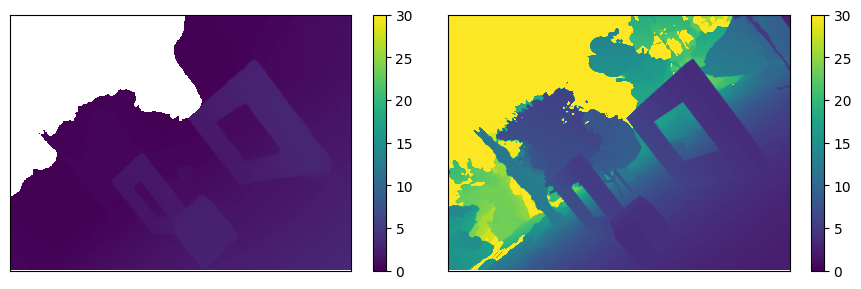

In [105]:
def plot_depths(pred, gt):
    fig = plt.figure(figsize=(9, 3))
    v0 = min(np.amin(pred), np.amin(gt))
    # v1 = max(np.amax(pred), np.amax(gt))
    v1 = 30.0
    params = { 'vmin': v0, 'vmax': v1, 'cmap': 'viridis', 'aspect': 'equal' }
    pred = np.where(depth_mask, pred, np.nan)
    plt.subplot(1, 2, 1)
    plt.imshow(pred, **params)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(gt, **params)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_depths(pred_depth, gt_depth)


Linear regression

-0.6135394539521496 2.886177465048755
L1: 0.39605221420705844


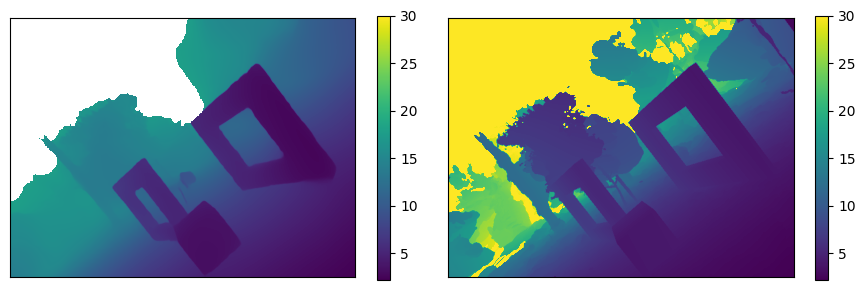

In [106]:
def ymap(y):
    return np.log(y)

def xmap(x):
    return np.exp(x)

def linregress(x, y):
    shape = x.shape
    x, y = x.flatten(), ymap(y).flatten()
    A = np.stack((x, np.ones_like(x)))
    A[:, ~depth_mask.flatten()] = 0.0
    m, b = np.linalg.solve(A@A.T, A@y)
    print(m, b)
    return xmap((m * x + b).reshape(shape))

def l1():
    return (np.abs(y1-gt_depth) * depth_mask).sum() / (gt_depth * depth_mask).sum()

y1 = linregress(pred_depth, gt_depth)
print('L1:', l1())
plot_depths(y1, gt_depth)


Linear regression with position

[ 2.82350196 -0.5169419  -0.16607743 -0.23993189]
L1: 0.38778174586854547


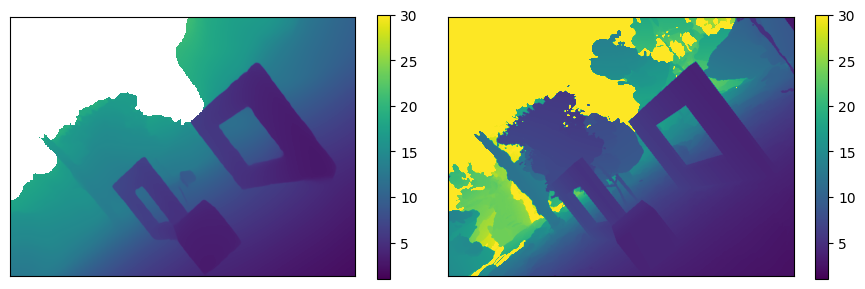

In [107]:
def linregress_with_pos(x, y):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), ymap(y).flatten()
    u, v = u.flatten(), v.flatten()
    A = np.stack((np.ones_like(x), x, u, v))
    A[:, ~depth_mask.flatten()] = 0.0
    c = np.linalg.solve(A@A.T, A@y)
    print(c)
    return xmap((c @ A).reshape((h, w)))

y1 = linregress_with_pos(pred_depth, gt_depth)
print('L1:', l1())
plot_depths(y1, gt_depth)


Linear least squares, embedded depth

n=3
[ 1.96179694 -0.63211627  0.14607457 -0.0170181 ]
L1: 0.38771674447341387


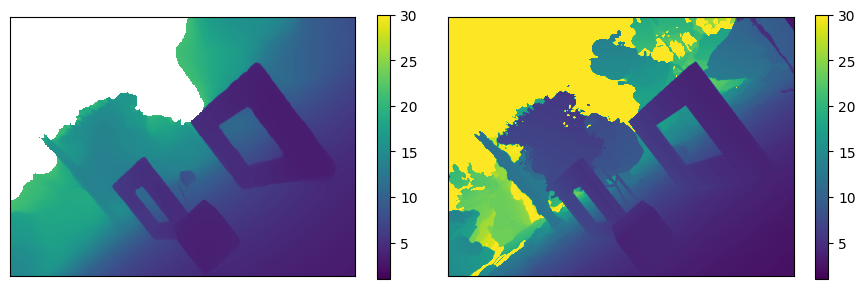

n=6
[ 2.07738793 -0.79849043 -0.30687964  0.44884323  0.1910986  -0.27259362
  0.06186052]
L1: 0.3837648244207705


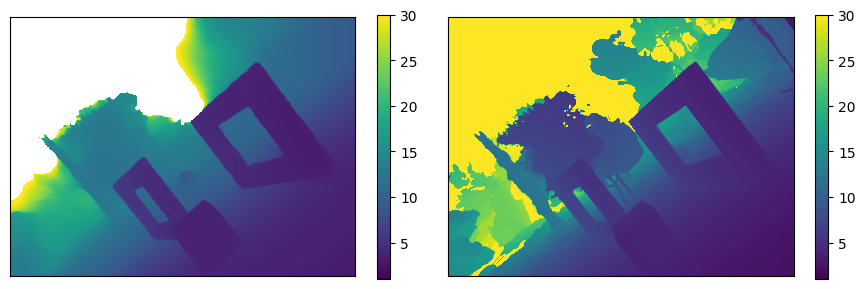

n=10
[  1.51593919  -0.18860208   7.86325882  -6.06521891 -19.95066228
  16.45708173  15.30046938 -15.43128615  -1.91434869   4.62376504
  -1.04616948]
L1: 0.468878958093307


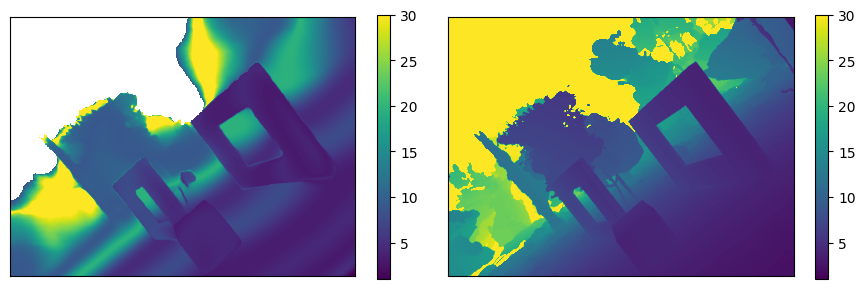

In [108]:
import math

def lsqr_ed(x, y, n):
    h, w = x.shape
    x, y = x.flatten(), ymap(y).flatten()
    x = x - np.mean(x[depth_mask.flatten()])
    x = x / np.std(x[depth_mask.flatten()])
    A = [np.ones_like(x)]
    for i in range(1, n+1):
        A.append(x**i)
    A = np.stack(A)
    A[:, ~depth_mask.flatten()] = 0.0
    c = np.linalg.solve(A@A.T, A@y)
    print(c)
    return xmap((c @ A).reshape((h, w)).clip(1e-3))

print("n=3")
y1 = lsqr_ed(pred_depth, gt_depth, 3)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("n=6")
y1 = lsqr_ed(pred_depth, gt_depth, 6)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("n=10")
y1 = lsqr_ed(pred_depth, gt_depth, 10)
print('L1:', l1())
plot_depths(y1, gt_depth)


Linear least squares, embedded depth and position

nd=4, np=1
14 coefficients
L1: 0.3242780563753192


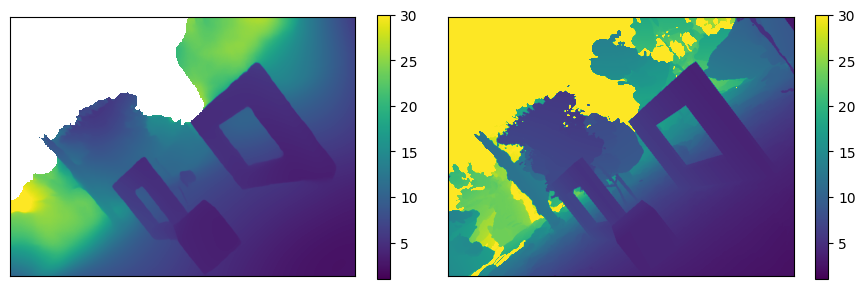

nd=4, np=2
30 coefficients
L1: 0.29634903511925864


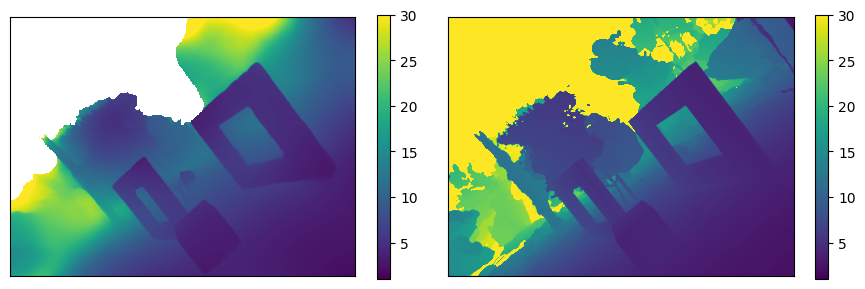

nd=4, np=3
54 coefficients
L1: 0.2875003314003881


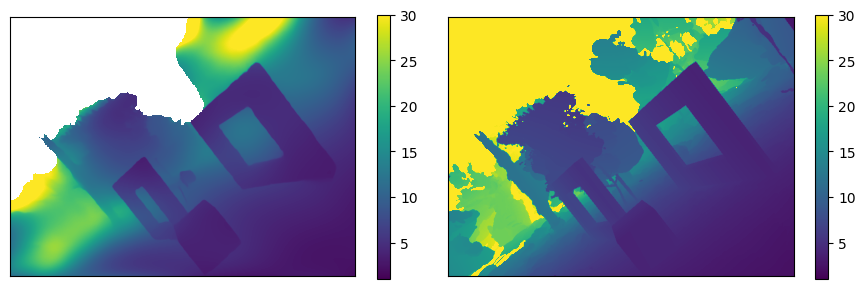

nd=4, np=4
86 coefficients
L1: 0.2834709586504973


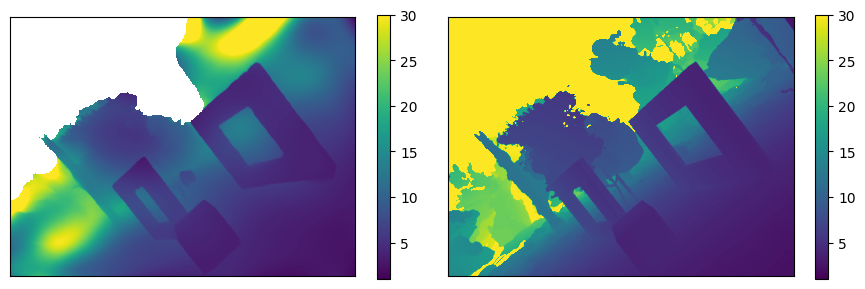

In [109]:
import math

def lsqr_edp(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), ymap(y).flatten()
    u, v = u.flatten(), v.flatten()
    x = x - np.mean(x[depth_mask.flatten()])
    x = x / np.std(x[depth_mask.flatten()])
    # depth embeddings
    A = [np.ones_like(x)]
    for i in range(1, nd+1):
        A.append(x**i / math.factorial(i))
    # position embeddings
    for i in range(npos+1):
        for j in range(npos+1):
            A.append(np.cos(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
            if j != 0:
                A.append(np.cos(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
            if i != 0:
                A.append(np.sin(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
            if i != 0 and j != 0:
                A.append(np.sin(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
    A = np.stack(A)
    A[:, ~depth_mask.flatten()] = 0.0
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return xmap((c @ A).reshape((h, w)).clip(1e-3))

print("nd=4, np=1")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 1)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=3")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 3)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=4")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 4)
print('L1:', l1())
plot_depths(y1, gt_depth)


Linear least squares, embedded and fused depth and positions

nd=3, np=1
36 coefficients
L1: 0.2827748146795366


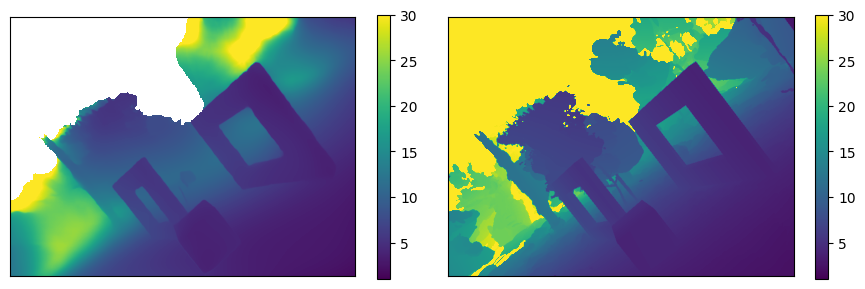

nd=1, np=2
50 coefficients
L1: 0.28593738461564217


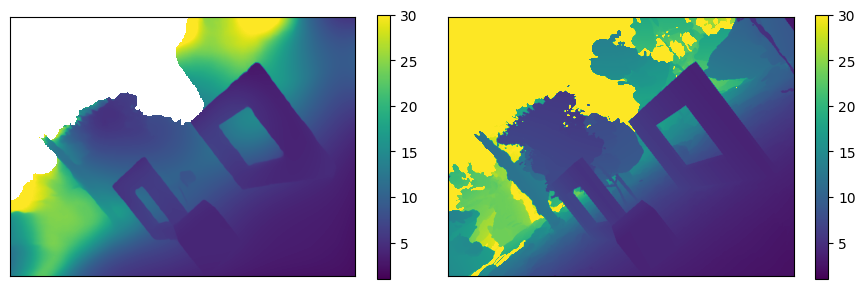

nd=2, np=2
75 coefficients
L1: 0.28948700797907634


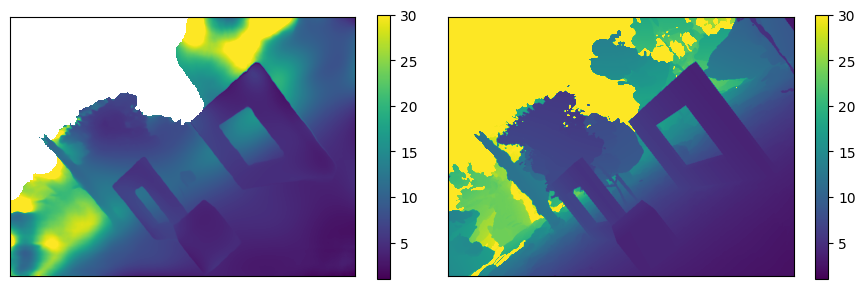

nd=3, np=2
100 coefficients
L1: 472912.5869012661


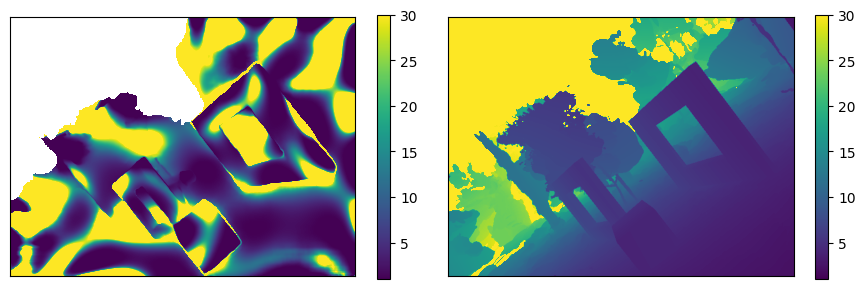

nd=4, np=2
125 coefficients
L1: 0.2612528776338464


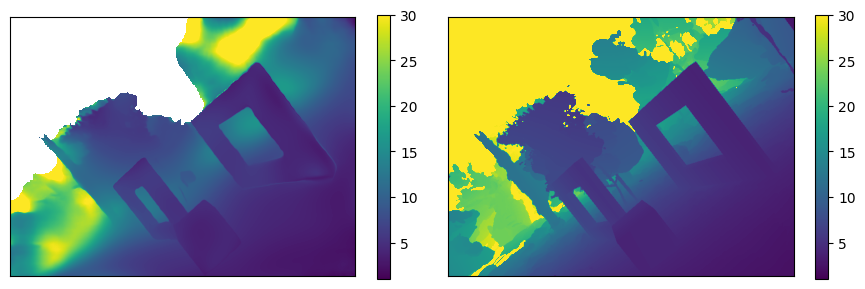

nd=2, np=3
147 coefficients
L1: 7.848733525858081


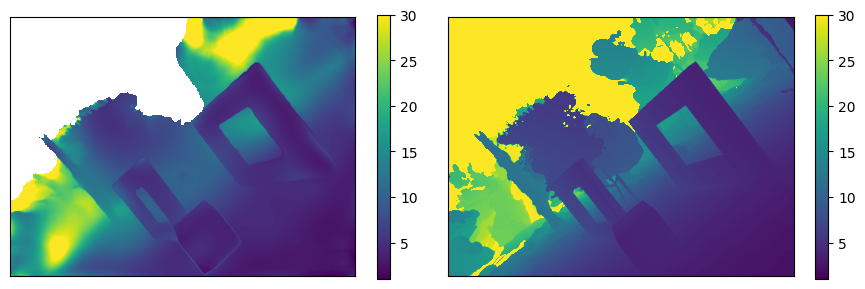

In [110]:
def lsqr_efdp(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), ymap(y).flatten()
    u, v = u.flatten(), v.flatten()
    x = x - np.mean(x[depth_mask.flatten()])
    x = x / np.std(x[depth_mask.flatten()])
    A = []
    for k in range(nd+1):
        ed = x**k / math.factorial(k)
        for i in range(npos+1):
            for j in range(npos+1):
                A.append(ed*np.cos(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
                if j != 0:
                    A.append(ed*np.cos(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
                if i != 0:
                    A.append(ed*np.sin(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
                if i != 0 and j != 0:
                    A.append(ed*np.sin(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
    A = np.stack(A)
    A[:, ~depth_mask.flatten()] = 0.0
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return xmap((c @ A).reshape((h, w)).clip(1e-3))

print("nd=3, np=1")
y1 = lsqr_efdp(pred_depth, gt_depth, 3, 1)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=1, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 1, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=2, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 2, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=3, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 3, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 4, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=2, np=3")
y1 = lsqr_efdp(pred_depth, gt_depth, 2, 3)
print('L1:', l1())
plot_depths(y1, gt_depth)


Linear least squares, individual embeddings

nd=4, np=1
9 coefficients
L1: 0.3793789898793189


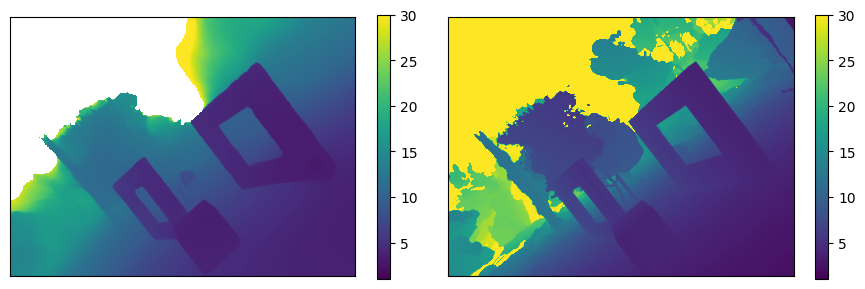

nd=4, np=2
13 coefficients
L1: 0.35749835824219356


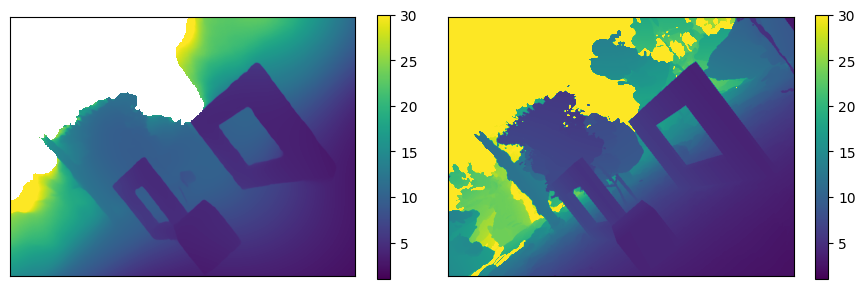

nd=4, np=12
53 coefficients
L1: 0.34334804195737173


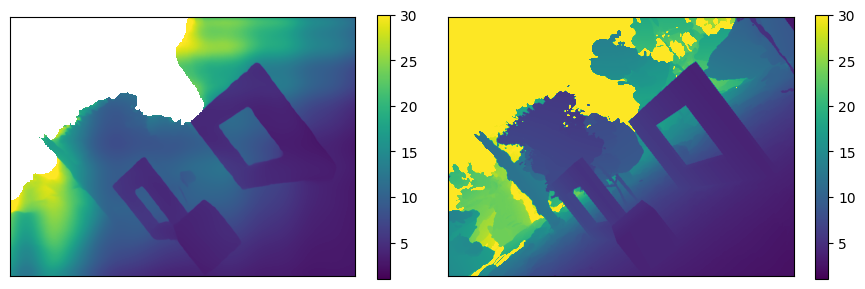

In [111]:
def lsqr_ie(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), ymap(y).flatten()
    u, v = u.flatten(), v.flatten()
    x = x - np.mean(x[depth_mask.flatten()])
    x = x / np.std(x[depth_mask.flatten()])
    # depth embeddings
    A = [np.exp(-x)]
    for i in range(1, nd+1):
        A.append(x**i / math.factorial(i) * np.exp(-x))
    # individual position embeddings
    for i in range(1, npos+1):
        A.append(np.cos(math.pi/2*i*u))
        A.append(np.sin(math.pi/2*i*u))
    for i in range(1, npos+1):
        A.append(np.cos(math.pi/2*i*v))
        A.append(np.sin(math.pi/2*i*v))
    A = np.stack(A)
    A[:, ~depth_mask.flatten()] = 0.0
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return xmap((c @ A).reshape((h, w)).clip(1e-3))

print("nd=4, np=1")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 1)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 2)
print('L1:', l1())
plot_depths(y1, gt_depth)

print("nd=4, np=12")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 12)
print('L1:', l1())
plot_depths(y1, gt_depth)
